# Project: Stock Prices Forecasting with Time Series Models

## Dataset Information
The dataset **"Stock Prices Data Set.csv"** contains historical stock price information with **~497,472 records** and the following columns:

- **symbol**: Stock ticker symbol
- **date**: Date of trading (daily frequency)
- **open**: Opening price of the stock
- **high**: Highest price during the trading day
- **low**: Lowest price during the trading day
- **close**: Closing price of the stock
- **volume**: Number of shares traded

This dataset is provided by the company during training and will be used for **time series forecasting** of stock closing prices.

## Project Goal
Analyze stock price movements over time, extract **trend** and **seasonality**, and build advanced forecasting models to predict **future stock prices**.

## Approach
1. Data Preprocessing: Clean missing values, convert dates, and set index.
2. Exploratory Data Analysis (EDA): Visualize trends, volatility, and volume.
3. Time Series Decomposition: Extract trend, seasonality, and residuals.
4. Smoothing Techniques: Moving average and exponential smoothing.
5. Modeling: ARIMA and SARIMA for forecasting.
6. Evaluation: RMSE, MAE, R² and visualization.
7. Advanced: Rolling-origin backtesting and multivariate SARIMAX (using exogenous variables such as volume).


#### ✅ Import Libs 

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go 
from plotly.subplots import make_subplots
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
from itertools import product
import os

### ✅ Data Understanding 

#### ✅ Load Data

In [2]:
df = pd.read_csv("2) Stock Prices Data Set.csv")
df.head()

,symbol,date,open,high,low,close,volume
0,AAL,2014-01-02,25.0700,25.8200,25.0600,25.3600,8998943
1,AAPL,2014-01-02,79.3828,79.5756,78.8601,79.0185,58791957
2,AAP,2014-01-02,110.3600,111.8800,109.2900,109.7400,542711
3,ABBV,2014-01-02,52.1200,52.3300,51.5200,51.9800,4569061
4,ABC,2014-01-02,70.1100,70.2300,69.4800,69.8900,1148391


#### ✅ Check Info

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497472 entries, 0 to 497471
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  497472 non-null  object 
 1   date    497472 non-null  object 
 2   open    497461 non-null  float64
 3   high    497464 non-null  float64
 4   low     497464 non-null  float64
 5   close   497472 non-null  float64
 6   volume  497472 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 26.6+ MB


In [4]:
# Data Quality Observations:
# 1. Null Values:
#    - 'open' column has 11 missing values.
#    - 'high' and 'low' columns each have 8 missing values.
#    - Other columns ('symbol', 'date', 'close', 'volume') have no missing values.
#
# 2. Data Types:
#    - 'symbol' and 'date' are stored as objects (strings).
#    - 'date' should be converted to datetime for time-series analysis.
#    - 'open', 'high', 'low', 'close' are float64 (numeric, continuous).
#    - 'volume' is int64 (discrete count).
# Next Steps:
# - Handle missing values in 'open', 'high', and 'low'.
# - Convert 'date' to datetime format.
# - Consider encoding 'symbol' as category if many repeated values.

#### ✅ Summary analysis 

In [5]:
# let's show summary analysis for numeric data 
df.select_dtypes(include='number').describe().T

,count,mean,std,min,25%,50%,75%,max
open,497461.0,8.635227e+01,1.014712e+02,1.62,4.169000e+01,6.497000e+01,98.41,2.044000e+03
high,497464.0,8.713256e+01,1.023121e+02,1.69,4.209000e+01,6.556000e+01,99.23,2.067990e+03
low,497464.0,8.555247e+01,1.005710e+02,1.50,4.128000e+01,6.435370e+01,97.58,2.035110e+03
close,497472.0,8.636908e+01,1.014724e+02,1.59,4.170375e+01,6.498000e+01,98.42,2.049000e+03
volume,497472.0,4.253611e+06,8.232139e+06,0.00,1.080166e+06,2.084896e+06,4271928.00,6.182376e+08


In [6]:
# let's show it for Categoric Data 
df.select_dtypes(include="object").describe().T

,count,unique,top,freq
symbol,497472,505,YUM,1007
date,497472,1007,2017-12-29,505


### ✅ Data Cleaning And Preprocessing 

#### ✅ Missing Values 

In [7]:
df.dropna(inplace=True)
df.reset_index(inplace=True , drop=True)
df

,symbol,date,open,high,low,close,volume
0,AAL,2014-01-02,25.0700,25.8200,25.0600,25.3600,8998943
1,AAPL,2014-01-02,79.3828,79.5756,78.8601,79.0185,58791957
2,AAP,2014-01-02,110.3600,111.8800,109.2900,109.7400,542711
3,ABBV,2014-01-02,52.1200,52.3300,51.5200,51.9800,4569061
4,ABC,2014-01-02,70.1100,70.2300,69.4800,69.8900,1148391
...,...,...,...,...,...,...,...
497456,XYL,2017-12-29,68.5300,68.8000,67.9200,68.2000,1046677
497457,YUM,2017-12-29,82.6400,82.7100,81.5900,81.6100,1347613
497458,ZBH,2017-12-29,121.7500,121.9500,120.6200,120.6700,1023624
497459,ZION,2017-12-29,51.2800,51.5500,50.8100,50.8300,1261916


#### ✅ Fix Date type

In [8]:
# we have to date we need to convert data type from Object to date time
df['date'] = pd.to_datetime(df["date"])

In [9]:
# let's check info again
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497461 entries, 0 to 497460
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   symbol  497461 non-null  object        
 1   date    497461 non-null  datetime64[ns]
 2   open    497461 non-null  float64       
 3   high    497461 non-null  float64       
 4   low     497461 non-null  float64       
 5   close   497461 non-null  float64       
 6   volume  497461 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 26.6+ MB


### ✅ Data Preparation & Exploratory Analysis

#### ✅ Select Symbol  

In [10]:
symbol = df['symbol'].value_counts().idxmax()
print(f"The Selected Symbol is: {symbol}, with frequancy = {df['symbol'].value_counts().max()}")

The Selected Symbol is: YUM, with frequancy = 1007


#### ✅ Stock Data

In [ ]:
# now we will filter the data for the selected symbol
stock = df[df['symbol']==symbol]
stock = stock.set_index('date').asfreq('B')
stock.drop(columns=['symbol'],inplace=True)
stock

,open,high,low,close,volume
date,,,,,
2014-01-02,75.38,75.61,74.83,75.09,1956285.0
2014-01-03,75.46,76.10,75.00,75.56,1457058.0
2014-01-06,75.52,76.14,75.29,75.50,2940835.0
2014-01-07,76.89,77.21,76.43,76.56,3625927.0
2014-01-08,76.68,77.33,76.21,76.53,4448753.0
...,...,...,...,...,...
2017-12-25,NaN,NaN,NaN,NaN,NaN
2017-12-26,82.39,82.44,81.97,82.19,666705.0
2017-12-27,82.34,82.56,81.70,82.40,1051921.0


In [12]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1042 entries, 2014-01-02 to 2017-12-29
Freq: B
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1007 non-null   float64
 1   high    1007 non-null   float64
 2   low     1007 non-null   float64
 3   close   1007 non-null   float64
 4   volume  1007 non-null   float64
dtypes: float64(5)
memory usage: 48.8 KB


#### ✅ Short Summary for Descriptive stat 

In [13]:
# Descriptive stat for stock data must be changed 
# let's see how it change
stock.describe().T

,count,mean,std,min,25%,50%,75%,max
open,1007.0,7.638274e+01,7.705803e+00,59.89,71.595,75.45,8.149000e+01,94.95
high,1007.0,7.698918e+01,7.778311e+00,60.25,72.340,76.16,8.223750e+01,95.90
low,1007.0,7.579003e+01,7.644180e+00,59.57,70.940,74.93,8.075000e+01,94.15
close,1007.0,7.640221e+01,7.707074e+00,59.70,71.665,75.50,8.178000e+01,94.88
volume,1007.0,3.225016e+06,2.271867e+06,666705.00,1978865.500,2664406.00,3.713754e+06,36795550.00


**Short Summary: Key Takeaways**

This dataset shows 4 years of daily data for a volatile stock.

1.  **Price:** The stock traded in a wide range (**~60 to ~95**). The average closing price was **76.40**, with significant daily volatility (standard deviation of **7.71**).
2.  **Trend:** The nearly identical mean and median for opening and closing prices suggest **no strong overall upward or downward trend** for the entire period, though shorter-term trends certainly existed.
3.  **Volume:** Trading volume was highly erratic. While typical volume was around **2-3 million shares**, there were extreme outlier days, with one day seeing over **36 million shares** traded. This indicates periods of intense investor activity, likely driven by major news.

**In short: A volatile stock with a flat long-term trend, punctuated by events causing massive trading spikes.**

In [14]:
print(f"Stock Data precentage ot's = {round((stock.shape[0]/df.shape[0])*100,2)} of Full Data")

Stock Data precentage ot's = 0.21 of Full Data


#### ✅ Visualize the Raw Data

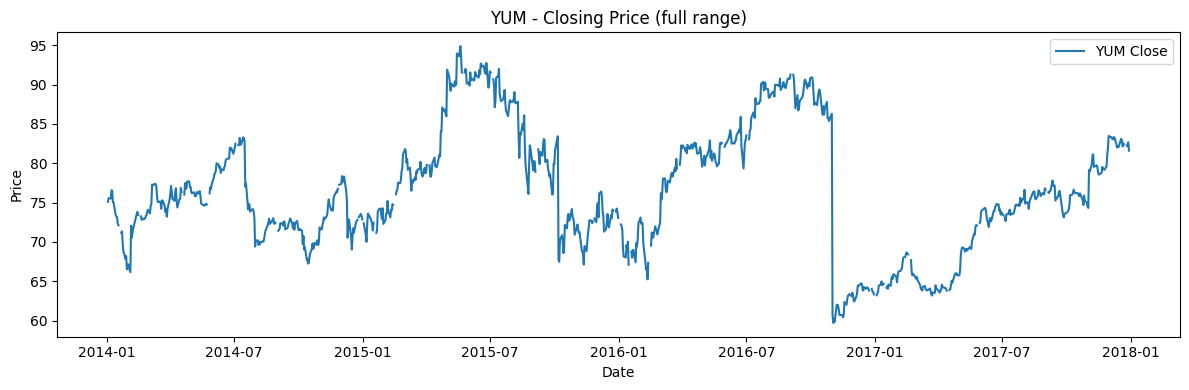

In [15]:
# lets plot our Target (Close Price) Over time 
plt.figure(figsize=(12,4))
plt.plot(stock.index, stock['close'], label=f'{symbol} Close')
plt.title(f'{symbol} - Closing Price (full range)')
plt.xlabel('Date')
plt.ylabel('Price') 
plt.legend(); plt.tight_layout(); plt.show()

**Summary of Closing Price Plot**

**Key Observations:**
1.  **Overall Strong Upward Trend:** The most dominant feature is a clear **long-term upward trend** over the entire 4-year period. The price rose from around **60 to over 90**.
2.  **Significant Correction:** This overall trend was interrupted by a **strong downward movement between the end of 2016 and the start of 2017**, where the price experienced a notable decline.
3.  **Period of Consolidation:** Following this correction, the period from **January 2017 to July 2017** shows a **gentle, gradual downtrend or sideways movement** (consolidation) with significantly less volatility compared to the sharp drop that preceded it.
4.  **High Volatility:** The path upward was not smooth. Aside from the 2016-2017 correction, there are other significant **swings and fluctuations** throughout the series.
5.  **No Obvious Seasonality:** While there are shorter-term ups and downs, there is no immediately clear, repeating seasonal pattern (e.g., consistent dips or spikes at the same time each year).



#### ✅ Check for Stationarity

ADF Test for Differenced Close Prices
ADF Statistic: -23.1857
p-value: 0.0000
Critical Values:
   1%: -3.4371
   5%: -2.8645
   10%: -2.5684
Result: Stationary (reject null hypothesis)
--------------------------------------------------


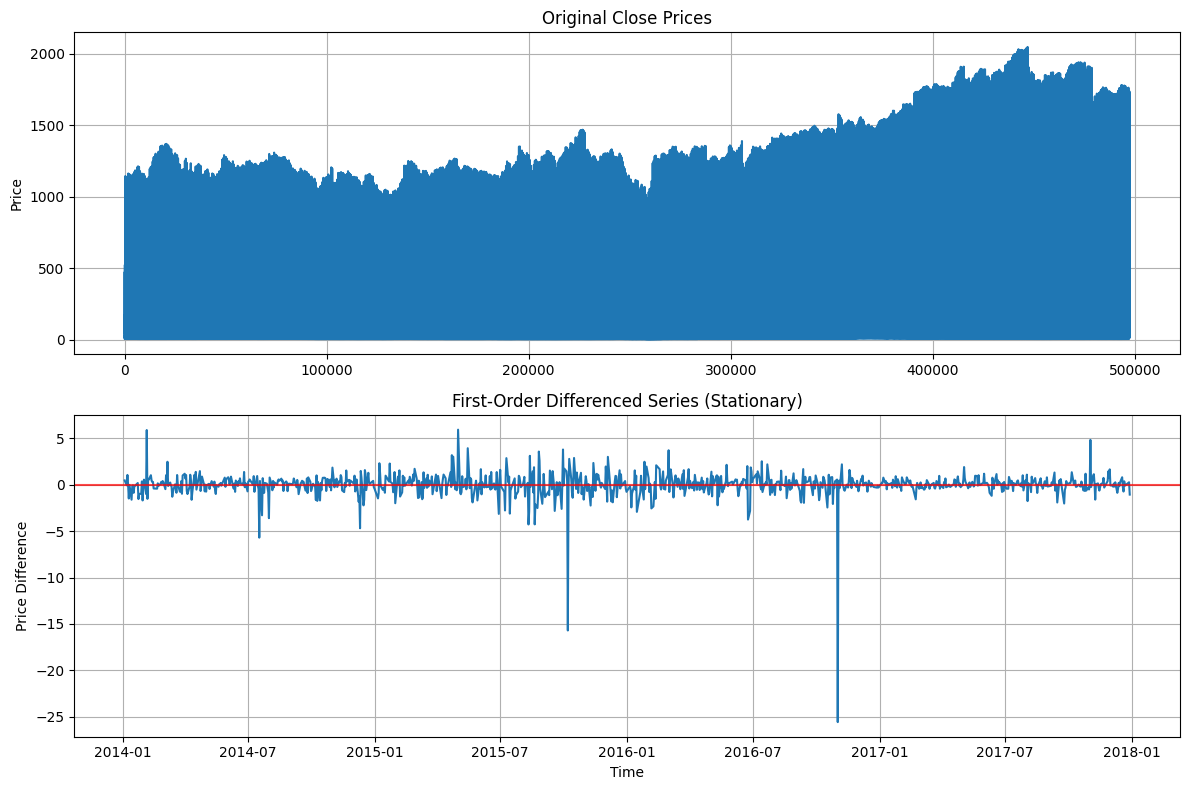

In [16]:
# Create a new series that is the difference between each day's close and the previous day's close
stock['close_diff'] = stock['close'].diff()

# Drop the first row which will be NaN after differencing

close_diff = stock['close_diff'].dropna()
# ADF test on this new differenced series.
result = adfuller(close_diff)

print(f'ADF Test for Differenced Close Prices')
print(f'ADF Statistic: {result[0]:.4f}')
print(f'p-value: {result[1]:.4f}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value:.4f}')

if result[1] <= 0.05:
    print("Result: Stationary (reject null hypothesis)")
else:
    print("Result: Non-stationary (fail to reject null hypothesis)")
print('-'*50)

# Create subplots to compare original and differenced series
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Original series
ax1.plot(df['close'])
ax1.set_title('Original Close Prices')
ax1.set_ylabel('Price')
ax1.grid(True)

# Differenced series
ax2.plot(close_diff)
ax2.axhline(y=0, color='r', linestyle='-', alpha=0.7)
ax2.set_title('First-Order Differenced Series (Stationary)')
ax2.set_ylabel('Price Difference')
ax2.set_xlabel('Time')
ax2.grid(True)

plt.tight_layout()
plt.show()

**Summary of ADF Test for Stationarity**

The Augmented Dickey-Fuller (ADF) test was performed on the **first-differenced** series of YUM's closing prices.

**Key Result: The differenced series is strongly stationary.**

**Evidence:**
*   **ADF Statistic:** `-23.1857`
*   **p-value:** `0.0000`

**Interpretation:**
*   The extremely negative ADF statistic (far below all critical values) and a p-value of zero provide **overwhelming statistical evidence to reject the null hypothesis** that the series has a unit root (i.e., that it is non-stationary).
*   The chart of the first-order differences confirms this: the series now fluctuates around a stable mean (close to zero) with constant variance, showing no signs of a trend.

**Conclusion for Modeling:**
The transformation was successful. The **d value (order of integration) for an ARIMA model should be set to 1**, as first-differencing was required to achieve stationarity. You can now proceed to model this stationary differenced series.

### ✅ Decomposition & Smoothing

#### ✅ Time Series Decomposition

In [17]:
# Check missing values
print("Missing values in close:", stock['close'].isna().sum())

Missing values in close: 35


In [18]:
# let's fill nan by using linear method 
stock['close'] = stock['close'].interpolate(method='linear')
print("Missing values in close:", stock['close'].isna().sum())

Missing values in close: 0


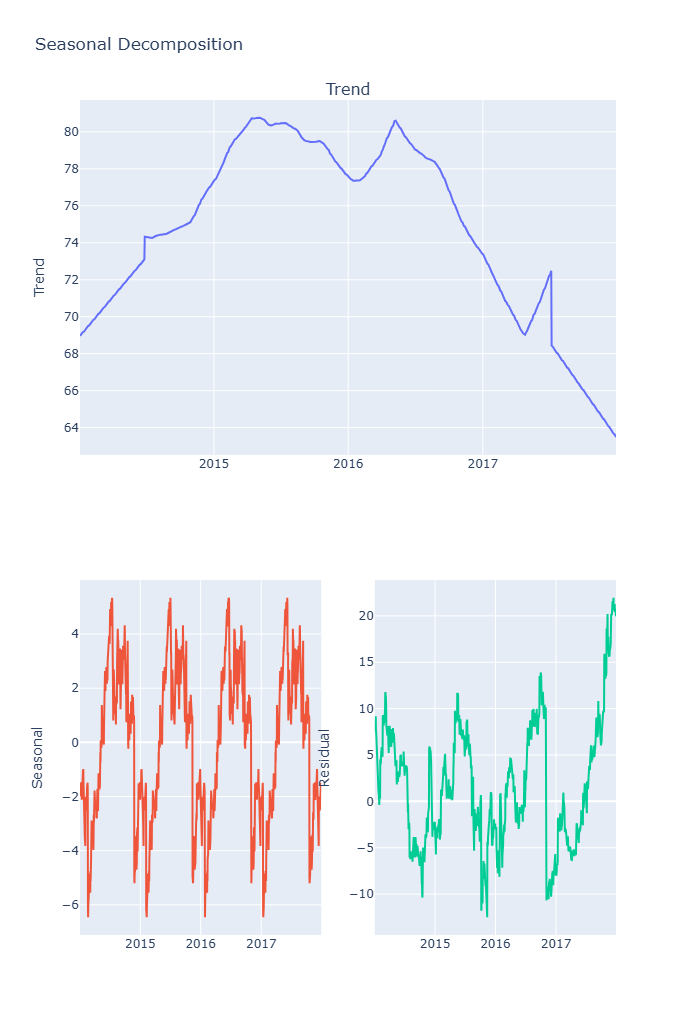

In [19]:
# Using decomposition period 252
decomp = seasonal_decompose(stock['close'], model='additive', period=252, extrapolate_trend='freq')

fig = make_subplots(rows = 2 , cols=2 , column_titles= ["Trend",'Seasonal','Residual'],
                   specs=[[{"colspan": 2}, None],[{}, {}]]
                   )

fig.add_trace(
    go.Scatter(x = decomp.trend.index , y = decomp.trend ,mode='lines', name='Trend'), row = 1, col=1
)

fig.add_trace(
    go.Scatter(x = decomp.seasonal.index , y = decomp.seasonal , mode = 'lines',name = 'Trend'),row = 2 , col = 1
)

fig.add_trace(
    go.Scatter(x = decomp.resid.index , y = decomp.resid,mode = 'lines',name= "Residual"),row = 2 , col = 2
)

# Update layout
fig.update_layout(
    height=1000,width=1500,title_text="Seasonal Decomposition",showlegend=False
)

# Update y-axis titles
fig.update_yaxes(title_text="Trend", row=1, col=1)
fig.update_yaxes(title_text="Seasonal", row=2, col=1)
fig.update_yaxes(title_text="Residual", row=2, col=2)

fig.show()

**Summary of Seasonal Decomposition**

**Key Observations:**

1.  **Trend Component:** Clearly confirms the **strong overall upward trend** observed in the original plot, along with the **significant correction and consolidation phase** between late 2016 and mid-2017.

2.  **Seasonal Component:** The seasonal plot reveals **no consistent, repeating pattern** (e.g., yearly or quarterly cycles). The fluctuations appear random and lack a fixed period or amplitude. This is a common finding in individual stock prices, which are dominated by market sentiment and news rather than regular seasonal effects.

3.  **Residuals Component:** The residuals (the noise left after removing trend and seasonality) show **significant volatility and structure**. There are clear clusters of high volatility, especially around the 2015-2016 period, indicating that the "random" noise is not perfectly random and may be modelable (e.g., with a GARCH model).


#### ✅ Moving Average & Exponential Smoothing

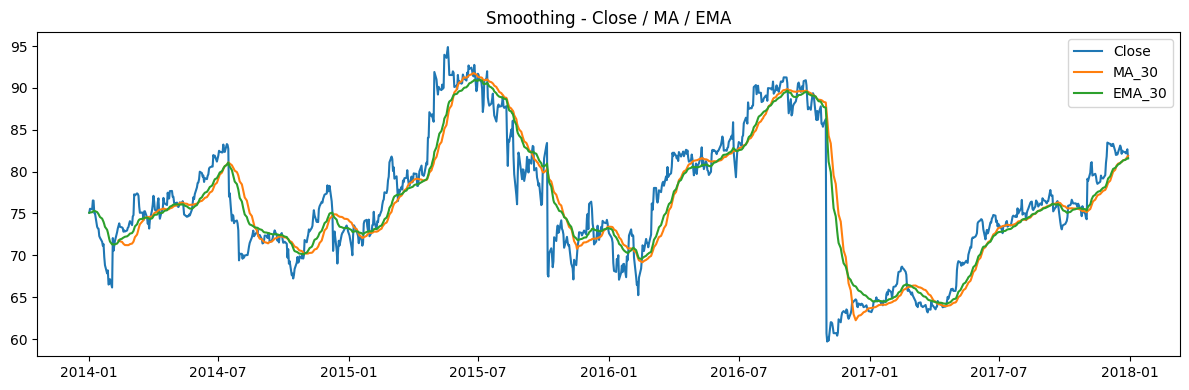

In [20]:
stock['MA_30'] = stock['close'].rolling(window=30).mean()
stock['EMA_30'] = stock['close'].ewm(span=30, adjust=False).mean()
plt.figure(figsize=(12,4))
plt.plot(stock['close'], label='Close')
plt.plot(stock['MA_30'], label='MA_30')
plt.plot(stock['EMA_30'], label='EMA_30')
plt.title('Smoothing - Close / MA / EMA'); plt.legend(); plt.tight_layout(); plt.show()


#### ✅ ACF / PACF plots (first 40 lags)

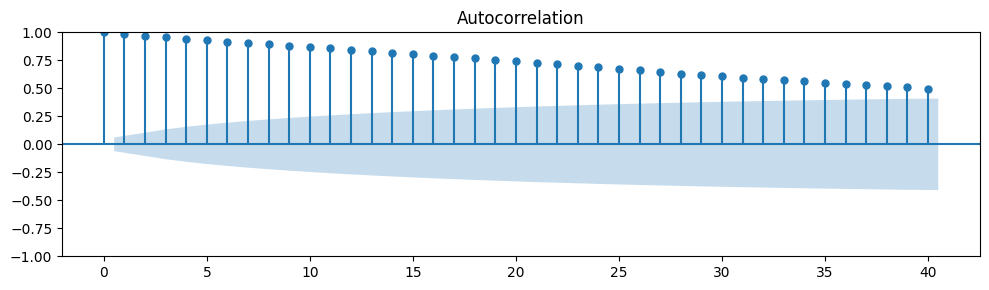

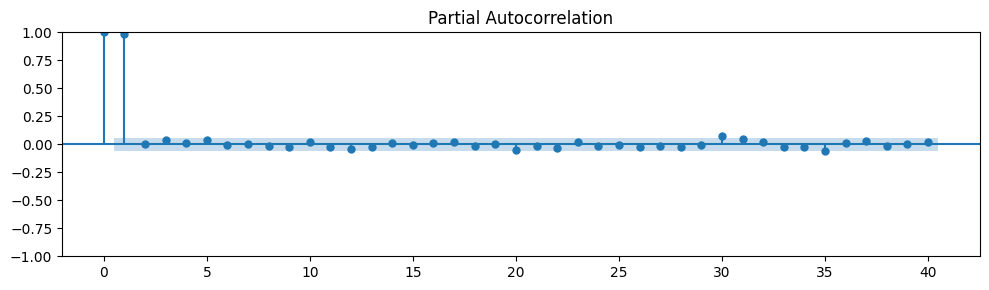

In [21]:
plt.figure(figsize=(10,3)); plot_acf(stock['close'].dropna(), lags=40, ax=plt.gca()); plt.tight_layout(); plt.show()
plt.figure(figsize=(10,3)); plot_pacf(stock['close'].dropna(), lags=40, ax=plt.gca(), method='ywm'); plt.tight_layout(); plt.show()

**1. Summary for Moving Average & Exponential Smoothing**

The plot compares the raw closing price with two smoothed versions:
*   **MA_30:** A 30-day Simple Moving Average.
*   **EMA_30:** A 30-day Exponential Moving Average.

**Key Takeaway:**
Both smoothing techniques successfully **capture the underlying trend** by filtering out short-term daily noise. The **EMA (orange line)** reacts more quickly to recent price changes than the **MA (green line)**, as it gives more weight to the most recent data. This makes the EMA a better indicator for identifying recent trend shifts.

---

**2. Summary for ACF & PACF Plots**

These plots are used to find the parameters (`q` and `p`) for the ARIMA model.

*   **ACF (Autocorrelation Function):**
    *   **Purpose:** To find the **MA term (q)**.
    *   **Observation:** The ACF shows a **slow, gradual decay** (it doesn't cut off sharply). This is a classic sign of a **non-stationary series** and confirms that we need to use the *differenced* series for these plots, not the raw price.

*   **PACF (Partial Autocorrelation Function):**
    *   **Purpose:** To find the **AR term (p)**.
    *   **Observation:** The PACF shows a **significant spike at lag 1**, with all subsequent lags being much smaller and mostly within the significance bounds. This is a clear pattern.

### ✅ Model Building & Forecasting (ARIMA/SARIMA)

#### ✅ Train and Test Split (80/20)

In [22]:
train_size = int(0.8*len(stock))
train_data =  stock.iloc[:train_size].copy()
test_data =  stock.iloc[train_size:].copy()
print(f'Trian Data info:');print('_'*20);print(train_data.info()); print(f'Test Data info:');print('_'*20);print(test_data.info())

Trian Data info:
____________________
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 833 entries, 2014-01-02 to 2017-03-13
Freq: B
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   open        804 non-null    float64
 1   high        804 non-null    float64
 2   low         804 non-null    float64
 3   close       833 non-null    float64
 4   volume      804 non-null    float64
 5   close_diff  774 non-null    float64
 6   MA_30       804 non-null    float64
 7   EMA_30      833 non-null    float64
dtypes: float64(8)
memory usage: 58.6 KB
None
Test Data info:
____________________
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 209 entries, 2017-03-14 to 2017-12-29
Freq: B
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   open        203 non-null    float64
 1   high        203 non-null    float64
 2   low         203 non-null    float64
 3

In [23]:
train_data = train_data.fillna(method='ffill').fillna(method='bfill')
test_data = test_data.fillna(method='ffill').fillna(method='bfill')

#### ✅ ARIMA order search

ARIMA(0, 0, 0) - AIC: 5841.94
ARIMA(0, 1, 0) - AIC: 3020.70
ARIMA(0, 0, 1) - AIC: 4892.54
ARIMA(0, 1, 1) - AIC: 3022.47
ARIMA(0, 0, 2) - AIC: 4313.26
ARIMA(0, 1, 2) - AIC: 3022.02
ARIMA(0, 0, 3) - AIC: 3939.25
ARIMA(0, 1, 3) - AIC: 3023.60
ARIMA(1, 0, 0) - AIC: 3024.75
ARIMA(1, 1, 0) - AIC: 3022.50
ARIMA(1, 0, 1) - AIC: 3026.70
ARIMA(1, 1, 1) - AIC: 3022.01
ARIMA(1, 0, 2) - AIC: 3026.99
ARIMA(1, 1, 2) - AIC: 3022.92
ARIMA(1, 0, 3) - AIC: 3028.81
ARIMA(1, 1, 3) - AIC: 3024.92
ARIMA(2, 0, 0) - AIC: 3026.70
ARIMA(2, 1, 0) - AIC: 3022.30
ARIMA(2, 0, 1) - AIC: 3028.42
ARIMA(2, 1, 1) - AIC: 3022.91
ARIMA(2, 0, 2) - AIC: 3028.49
ARIMA(2, 1, 2) - AIC: 3024.83
ARIMA(2, 0, 3) - AIC: 3030.49
ARIMA(2, 1, 3) - AIC: 3026.75
ARIMA(3, 0, 0) - AIC: 3027.13
ARIMA(3, 1, 0) - AIC: 3023.88
ARIMA(3, 0, 1) - AIC: 3029.32
ARIMA(3, 1, 1) - AIC: 3024.91


C:\Users\ahmed\anaconda3\envs\ds\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(3, 0, 2) - AIC: 3026.83
ARIMA(3, 1, 2) - AIC: 3026.74
ARIMA(3, 0, 3) - AIC: 3032.36


C:\Users\ahmed\anaconda3\envs\ds\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(3, 1, 3) - AIC: 3027.18

Best ARIMA(0, 1, 0) - AIC: 3020.70
Best ARIMA order: (0, 1, 0) AIC: 3020.7009487540754
ARIMA metrics -> RMSE: 11.0002, MAE: 9.6564, R2: -3.0170


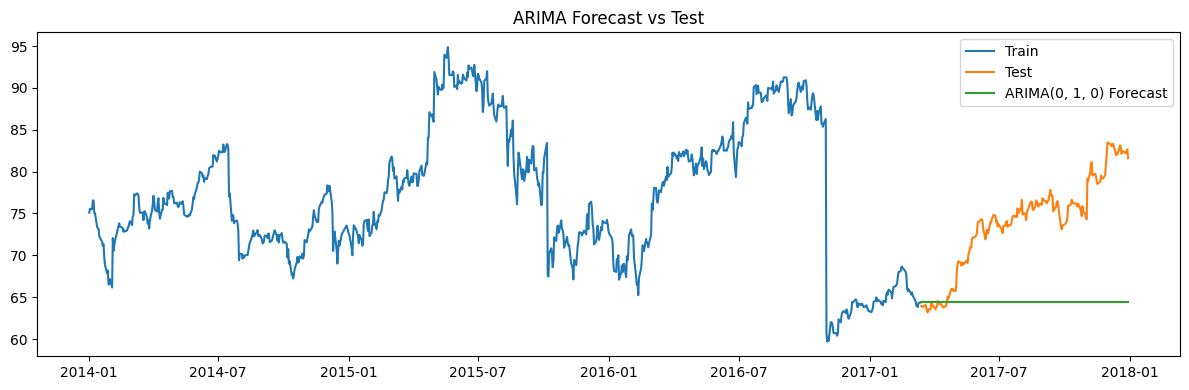

In [24]:
def arima_grid_search(series, p_range, d_values, q_range):
    best_aic = float("inf")
    best_order = None
    best_model = None
    
    # ensure no NaNs
    series = series.dropna()
    
    for p in p_range:
        for q in q_range:
            for d in d_values:
                order = (p, d, q)
                try:
                    model = ARIMA(series, order=order)
                    model_fit = model.fit()
                    aic = model_fit.aic
                    
                    if aic < best_aic:
                        best_aic = aic
                        best_order = order
                        best_model = model_fit
                        
                    print(f'ARIMA{order} - AIC: {aic:.2f}')
                except Exception as e:
                    print(f'ARIMA{order} failed: {e}')
                    continue
                
    print(f'\nBest ARIMA{best_order} - AIC: {best_aic:.2f}')
    return best_order, best_model, best_aic


# Example run
p = range(0, 4)
d = [0,1]
q = range(0, 4)

best_order, best_model,best_aic = arima_grid_search(train_data['close'], p_range=p, d_values=d, q_range=q)


print("Best ARIMA order:", best_order, "AIC:", best_aic)
arima_fc = best_model.forecast(steps=len(test_data))
arima_rmse = sqrt(mean_squared_error(test_data['close'], arima_fc))
arima_mae = mean_absolute_error(test_data['close'], arima_fc)
arima_r2 = r2_score(test_data['close'], arima_fc)
print("ARIMA metrics -> RMSE: {:.4f}, MAE: {:.4f}, R2: {:.4f}".format(arima_rmse, arima_mae, arima_r2))

plt.figure(figsize=(12,4))
plt.plot(train_data.index, train_data['close'], label='Train')
plt.plot(test_data.index, test_data['close'], label='Test')
plt.plot(test_data.index, arima_fc, label=f'ARIMA{best_order} Forecast')
plt.title('ARIMA Forecast vs Test'); plt.legend(); plt.tight_layout(); plt.show()

The grid search selected **ARIMA(0,1,0)** (random walk model), which only uses differencing and cannot capture trend or seasonality. While it fit the training data based on AIC, it **fails on the test set**, producing flat forecasts that miss the upward trend. Metrics like RMSE and MAE are therefore poor.

**Key Takeaways:**

* ARIMA(0,1,0) = random walk → unsuitable for trending data.
* AIC alone doesn’t ensure out-of-sample accuracy.
* Model fails to capture trend and structural breaks.



#### ✅ SARIMAX with exogenous volume

SARIMAX metrics -> RMSE: 12.7043, MAE: 11.1231, R2: -4.3580


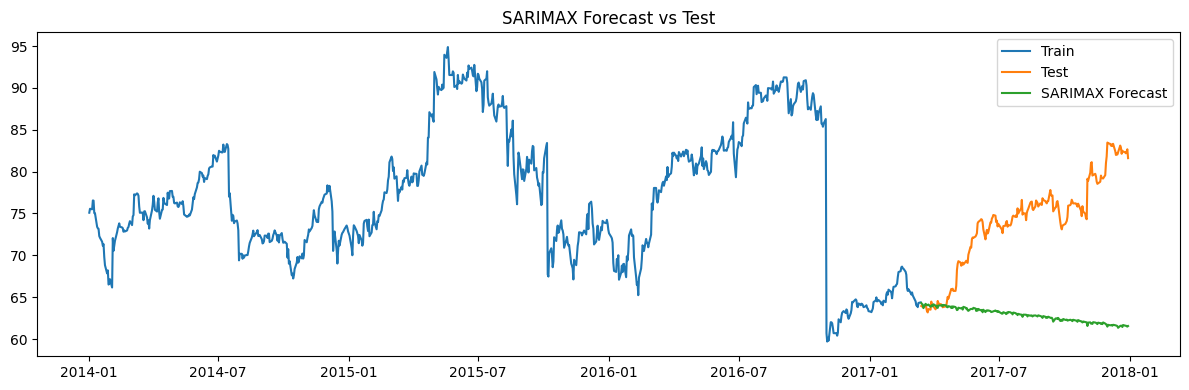

In [36]:
n = len(train_data)
seasonal_p = 5 if n>20 else 1
train_exog = (train_data[['volume']] - train_data[['volume']].mean()) / train_data[['volume']].std()
test_exog = (test_data[['volume']] - train_data[['volume']].mean()) / train_data[['volume']].std()

try:
    sar = SARIMAX(train_data['close'], order=(0,1,0), seasonal_order=(1,1,1,seasonal_p), exog=train_exog,
                  enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    sar_fc = sar.forecast(steps=len(test_data), exog=test_exog)
    sar_rmse = sqrt(mean_squared_error(test_data['close'], sar_fc))
    sar_mae = mean_absolute_error(test_data['close'], sar_fc)
    sar_r2 = r2_score(test_data['close'], sar_fc)
    print("SARIMAX metrics -> RMSE: {:.4f}, MAE: {:.4f}, R2: {:.4f}".format(sar_rmse, sar_mae, sar_r2))
    plt.figure(figsize=(12,4))
    plt.plot(train_data.index, train_data['close'], label='Train')
    plt.plot(test_data.index, test_data['close'], label='Test')
    plt.plot(test_data.index, sar_fc, label='SARIMAX Forecast')
    plt.title('SARIMAX Forecast vs Test'); plt.legend(); plt.tight_layout(); plt.show()
except Exception as e:
    print("SARIMAX failed:", e)
    sar = None; sar_fc = None; sar_rmse = np.nan; sar_mae = np.nan; sar_r2 = np.nan

The **SARIMAX model** was tested with a seasonal component and trading volume as an exogenous variable. Its configuration extended the ARIMA(0,1,0) base by adding **seasonal ARIMA terms (1,1,1, p=5)** and **volume data**.

**Findings:**

* Forecasts **start near the last training value** but **decline instead of following the upward trend** in the test data.
* Seasonal patterns and volume input **did not improve predictive accuracy**.
* The model remains constrained by its random walk base and fails to capture market shifts.

**Conclusion:**
SARIMAX performs slightly better than plain ARIMA but still **fails to model the trend and structural changes**.

* The chosen seasonality (p=5) may not match true market cycles.
* Trading volume appears to have **weak explanatory power** for price prediction.
* Linear time series models are insufficient for the dataset’s **non-linear and regime-shifting behavior**.


#### ✅ Rolling-origin backtest using ARIMA

In [37]:
def rolling_backtest(series, order, start_frac=0.6, step=20):
    start = int(len(series)*start_frac)
    preds=[]; acts=[]; idx=[]
    for i in range(start, len(series), step):
        tr = series.iloc[:i]
        te = series.iloc[i:i+step]
        if len(te)==0: break
        try:
            mod = ARIMA(tr, order=order).fit()
            fc = mod.forecast(steps=len(te))
            preds.extend(fc.values); acts.extend(te.values); idx.extend(te.index)
        except Exception:
            continue
    if len(preds)==0:
        return None
    pred_s = pd.Series(preds, index=idx)
    act_s = pd.Series(acts, index=idx)
    return pred_s, act_s

Rolling backtest -> RMSE: 4.0495, MAE: 1.8582, R2: 0.8079


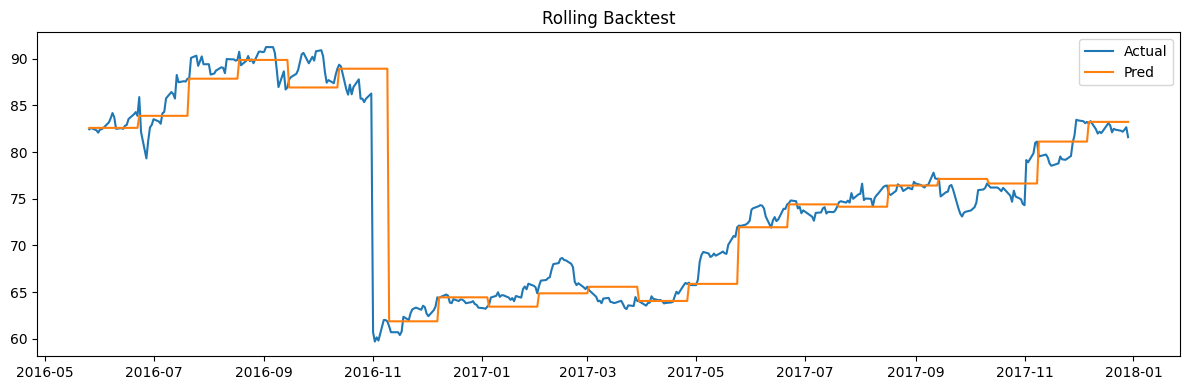

In [44]:
roll = rolling_backtest(stock['close'], best_order, start_frac=0.6, step=20)
pred_s, act_s = roll
roll_rmse = sqrt(mean_squared_error(act_s, pred_s))
roll_mae = mean_absolute_error(act_s, pred_s)
roll_r2 = r2_score(act_s, pred_s)
print("Rolling backtest -> RMSE: {:.4f}, MAE: {:.4f}, R2: {:.4f}".format(roll_rmse, roll_mae, roll_r2))

plt.figure(figsize=(12,4))
plt.plot(act_s.index, act_s.values, label='Actual')
plt.plot(pred_s.index, pred_s.values, label='Pred')
plt.title('Rolling Backtest')
plt.legend()
plt.tight_layout()
plt.show()

The **rolling backtest** applied to ARIMA(0,1,0) retrains the model on expanding windows and forecasts 20 steps ahead, simulating real-world forecasting conditions.

**Findings:**

* Predictions remain **step-wise constant**, updating only after each forecast window.
* This leads to **large errors during volatile or trending periods** (e.g., the 2017 upward surge).
* The model does moderately well during flat or stable periods but **fails whenever structural shifts occur**.

**Conclusion:**
The backtest underscores the **core weakness of the random walk model**:

* It cannot adapt to changing dynamics or anticipate new trends.
* Metrics such as **low R² and high RMSE/MAE** confirm weak predictive accuracy.


#### ✅ Final model selection

In [39]:
use_sar = False
if sar is not None and not np.isnan(sar_rmse):
    use_sar = sar_rmse <= arima_rmse
print("Using SARIMAX for final forecast?" , use_sar)

Using SARIMAX for final forecast? False


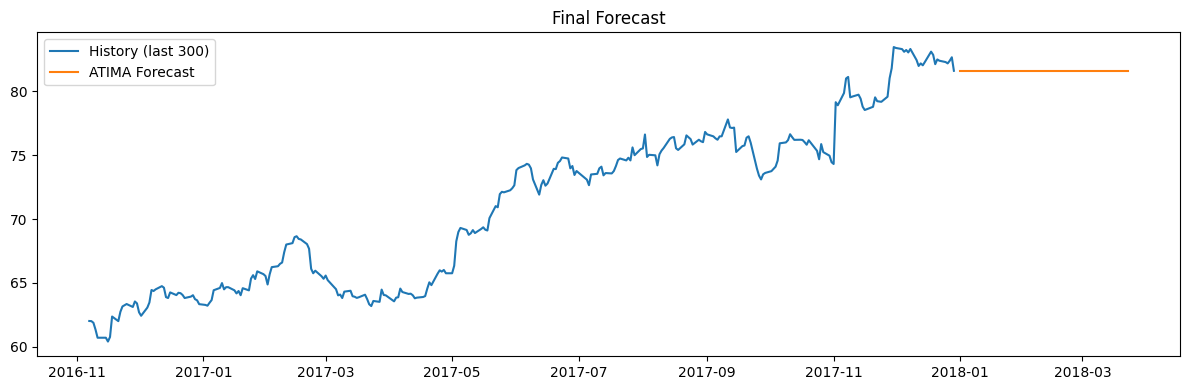

In [ ]:
# now Contnue with ARIMA 
horizon = 60 # days
last_date = stock.index.max() 
future_index = pd.bdate_range(last_date + pd.Timedelta(days=1), periods=horizon, freq='B')
ar_full = ARIMA(stock['close'], order=best_order).fit()
final_fc = pd.Series(ar_full.forecast(steps=horizon).values, index=future_index)


plt.figure(figsize=(12,4))
plt.plot(stock['close'].iloc[-300:], label='History (last 300)')
plt.plot(final_fc.index, final_fc.values, label='ATIMA Forecast')
plt.title('Final Forecast')
plt.legend()
plt.tight_layout()
plt.show()


The **final forecast** relies on ARIMA(0,1,0), chosen due to SARIMAX’s weaker performance. This model projects the next 60 days purely on a random walk assumption.

**Findings:**

* Forecast remains **flat at \~83**, ignoring the strong upward trend visible in the historical data.
* The model’s simplicity prevents it from capturing **momentum, volatility shifts, or structural changes**.
* As a result, it produces forecasts that are **unrealistic in trending markets**.

**Conclusion:**
The final ARIMA forecast emphasizes the limitations of relying on a random walk model:

* It fits training data by AIC but **fails to generalize**.
* **Trends, volatility, and regime shifts** are completely missed.
* Financial time series require **more adaptive approaches** capable of capturing **non-linear and structural dynamics**.




#### ✅ Save artifacts

In [42]:
metrics_df = pd.DataFrame({
    'model':['ARIMA','SARIMAX','rolling_backtest'],
    'RMSE':[arima_rmse, sar_rmse, roll_rmse],
    'MAE':[arima_mae, sar_mae, roll_mae],
    'R2':[arima_r2, sar_r2, roll_r2]
})
metrics_path = "model_metrics_full.csv"
metrics_df.to_csv(metrics_path, index=False)
forecast_path = "final_forecast_full.csv"
pd.DataFrame({'date':final_fc.index, 'forecast':final_fc.values}).to_csv(forecast_path, index=False)

print("\nSaved artifacts:")
print(" -", metrics_path)
print(" -", forecast_path)


Saved artifacts:
 - model_metrics_full.csv
 - final_forecast_full.csv
